# The Future of Basketball Players

## Set up Environment

In [1]:
!python -c "import pandas as pd; print(pd.__version__)"

1.2.0


In [2]:
!pip show scipy

Name: scipy
Version: 1.6.0
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: c:\users\chris\.virtualenvs\mdsi_adsi_feb21_at1-1qc6rzga\lib\site-packages
Requires: numpy
Required-by: seaborn, scikit-learn, phik, pandas-profiling, missingno, imbalanced-learn, ImageHash


In [3]:
# Import modules
import os
import sys
import zipfile
import sklearn
import pandas as pd
import numpy as np
from joblib import dump, load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame
import random
from pytictoc import TicToc

# Instantiate global classes
t = TicToc()

In [4]:
# Make sure the directory is correct... every time.
i = 0
while i < 5:
    i += 1
    if not os.getcwd().split("\\")[-1] == "MDSI_ADSI_FEB21_AT1": os.chdir("..")
    else: break

# If not running in Jypyter, change the cwd to correct dir
if not "Interactive" in get_ipython().__class__.__name__:
    os.chdir("./notebooks/Chris")

# Set up sys path environment
if not os.path.abspath(".") in sys.path:
    sys.path.append(os.path.abspath("."))
else:
    sys.path.remove(os.path.abspath("."))
    sys.path.append(os.path.abspath("."))

### Custom Global Functions

In [5]:
def str_right(string:str, num_chars:int):
    """ Sub-Select the right-most number of characters from a string """
    assert isinstance(string, str)
    assert isinstance(num_chars, int)
    return string[-num_chars:]

def get_list_proportions(lst:list):
    assert isinstance(lst, (list, np.ndarray))
    prop = {}
    dist = list(set(lst))
    for val in dist:
        prop[val] = sum(map(lambda x: x==val, lst))/len(lst)
    return prop

## Get Data

In [6]:
# Check & Create directories
for dir in ["./data/processed/Chris", "./models/Chris"]:
    if not os.path.exists(dir): os.mkdir(dir)

In [ ]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ./data/raw --force --quiet

# Unzip the data
with zipfile.ZipFile("./data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("./data/raw")

# Delete the zip file
if os.path.exists("./data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("./data/raw/uts-advdsi-nba-career-prediction.zip")

In [8]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("./data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [9]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("./data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("./data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("./data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

### Data Dictionary

In [10]:
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

### Data Exploration

In [11]:
# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    IFrame(src="InitialReport.html", width="100%", height=600)
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

## Experimentation

### Data Manipulation

Steps:

1. Drop the `ID` column
1. Pop the `target` column
1. Scale the features
1. Split in to train/test

In [12]:
# Drop ID
data = data.drop(['Id','Id_old'], axis=1)

# Pop targ
feat = data.iloc[:,:-1].to_numpy()
targ = data.iloc[:,-1].to_numpy()

# Scale feat
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

# Tran/Test split
# Make sure you stratify the results based on the target variable
from sklearn.model_selection import train_test_split
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, stratify=targ, test_size=0.3, random_state=123)

In [13]:
# Dump your objects
dump(data, "./data/processed/Chris/data.joblib")
dump(feat, "./data/processed/Chris/feat.joblib")
dump(targ, "./data/processed/Chris/targ.joblib")
dump(feat_trn, "./data/processed/Chris/feat_trn.joblib")
dump(feat_val, "./data/processed/Chris/feat_val.joblib")
dump(targ_trn, "./data/processed/Chris/targ_trn.joblib")
dump(targ_val, "./data/processed/Chris/targ_val.joblib")
dump(scaler, "./models/Chris/scaler.joblib")

['../../models/Chris/scaler.joblib']

### Set up Experiment Space

In [14]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

In [15]:
def plot_roc_curve(targ:np.real, pred_prob:np.real):

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred_prob))

    # Generate data
    fpr, tpr, thresholds = roc_curve(targ, pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Generate plot
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC (AUC={:.3f}".format(roc_auc))
    plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics")
    plt.legend(loc="lower right")
    plt.show

    # Return
    return None

def save_reg_perf \
    ( targ:np.real
    , pred:np.real
    , pred_prob:np.real
    , name:str=None
    , df_metrics:pd.DataFrame=None
    , overwrite:bool=True
    , print:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Save model metrics to a dataframe.

    Args:
        targ (np.real): The actual values. Can be scalar or arrya, but must be Real numbers.
        pred (np.real): The prediction values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        pred_prob (np.real): The prediction probability values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        name (str, optional): The name of the data being calculated. If not given, will default to 'None'. Defaults to None.
        df_metrics (pd.DataFrame, optional): The data frame to be updated to contain the data. If not given, will update the `pred_scor` dataframe from the global scope. Defaults to None.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe. In SQL-speak: True=UPDATE, False=INSERT. Defaults to True.
        print (bool, optional): Wheather or not to turn off all printing. Defaults to True.
        print_matrix (bool, optional): Whether or not to print the confusion matrix. Defaults to True.
        print_plot (bool, optional): Whether or not to print the ROC plot. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe. Defaults to True.

    Raises:
        Assertions: Each parameter will be asserted to the proper type and attribute.

    Returns:
        pd.DataFrame: The updated dataframe.
    """    
    
    # Imports
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix as conf
    from sklearn.metrics import roc_auc_score as roc_auc
    from sklearn.metrics import f1_score as f1
    from sklearn.metrics import roc_curve, auc

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(pred_prob))
    if not name==None:
        assert np.isscalar(name)
        assert isinstance(name, str)
    if not df_metrics==None:
        assert isinstance(df_metrics, pd.DataFrame)
        assert df_metrics.columns == ["name","when","auc","sens","spec","f1"]
    for parameter in [overwrite, print_matrix, print_plot, print_dataframe]:
        assert isinstance(parameter, bool)

    # Ensure we're using the global object here
    global pred_scor

    # If you want to use another dataframe, go right ahead. Else, just keep it simple.
    if df_metrics==None: df = pred_scor
    else: df = df_metrics
    
    # Best to define name, but if blank then make None
    if name==None: name=="None"

    # Fix dimensions of the prob part
    if len(pred_prob.shape)>1:
        pred_prob = pred_prob[:,1]

    # Perform calculations
    val_now = pd.Timestamp.now().strftime('%d/%b %H:%M')
    val_auc = round(roc_auc(targ,pred_prob), 5)
    fpr, tpr, thre = roc_curve(targ, pred_prob, pos_label=1)
    tn, fp, fn, tp = conf(targ,pred).ravel()
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(targ,pred), 5)

    # Two different methods of updating the table. In SQL-Speak this is the difference between INSERT and UPDATE
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["when"]] = val_now
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "when": [val_now]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        df = df.append(new)

    # Fix Pandas indexes
    df.reset_index(drop=True, inplace=True)

    # Assign back to the global scope
    pred_scor = df

    # Print if needed
    if print:
        if print_matrix:
            display \
                ( pd.DataFrame \
                    ( conf(targ,pred)
                    , columns=pd.MultiIndex.from_tuples([("targ",0),("targ",1)])
                    , index=pd.MultiIndex.from_tuples([("pred",0),("pred",1)])
                    )
                )
        if print_plot:
            plot_roc_curve(targ, pred_prob)
        if print_dataframe:
            display(df)

    # Return
    return df

### Baseline

targ      
          0     1
pred 0    0  1331
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.5,1.0,0.0,0.90926


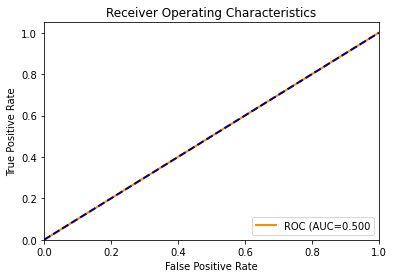

In [16]:
from statistics import mode

# Generate actuals
act = np.array(data['TARGET_5Yrs'])
# print("Actual proportions: {}".format(get_list_proportions(act)))

# Generate baseline, based on random re-sampling with the same proportions
random.seed(123)
# bas = random.choices([1,0], weights=list(get_list_proportions(act)), k=len(data))
bas = np.full(act.shape, mode(act))

# Check objects
# from src.utils.objects import check_object
# check_object(act, "act", _head_size=20)
# check_object(bas, "bas", _head_size=20)

# Check performance
save_reg_perf(act, bas, bas, "Raw baseline", print_matrix=True, print_plot=True, print_dataframe=False)

### Attempt #1: ElasticNet

targ      
          0     1
pred 0   22   377
     1   13  1988

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.9935,0.05514,0.91067


['../../models/Chris/01_LogisticRegression_Defaults.joblib']

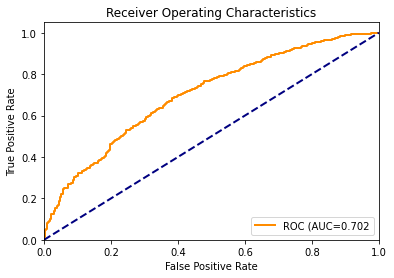

In [17]:
# Import model
from sklearn.linear_model import LogisticRegression

# Instantiate
reg = LogisticRegression(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# save_reg_perf(pred_trn, targ_trn, "LogisticRegression - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob[:,1], "LogisticRegression - Defaults")

# Backup
dump(reg, "./models/Chris/01_LogisticRegression_Defaults.joblib")

In [18]:
# Marginally better... barely worth it...

### Attempt #2: ElasticNetCV

targ      
          0     1
pred 0   50  1281
     1   38  6631

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.9943,0.03757,0.90954


['../../models/Chris/02_LogisticRegressionCV_Defaults.joblib']

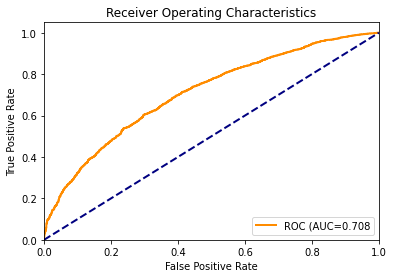

In [19]:
# Import model
from sklearn.linear_model import LogisticRegressionCV

# Instantiate
reg = LogisticRegressionCV(random_state=123)

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)
pred_prob = reg.predict_proba(feat)

# Check performance
save_reg_perf(targ, pred, pred_prob, "LogisticRegressionCV - Defaults")

# Backup
dump(reg, "./models/Chris/02_LogisticRegressionCV_Defaults.joblib")

In [20]:
# Slignt improvement. But nothing substantive yet.

### Attempt #3: RidgeClassifier

targ      
          0     1
pred 0    2   397
     1    3  1998

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.9985,0.00501,0.90901


['../../models/Chris/03_RidgeClassifier_Defaults.joblib']

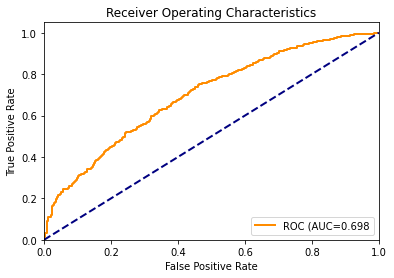

In [21]:
# Import model
from sklearn.linear_model import RidgeClassifier

# Instantiate
reg = RidgeClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.decision_function(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RidgeClassifier - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "RidgeClassifier - Defaults")

# Backup
dump(reg, "./models/Chris/03_RidgeClassifier_Defaults.joblib")

In [22]:
#

### Attempt #4: RidgeClassifierCV

targ      
          0     1
pred 0    5  1326
     1    2  6667

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.9985,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.9997,0.00376,0.90943


['../../models/Chris/04_RidgeClassifierCV_Defaults.joblib']

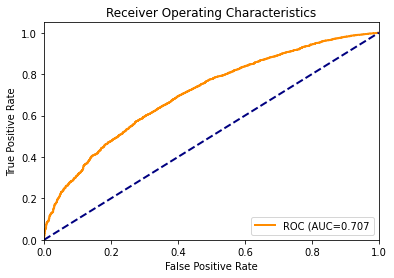

In [23]:
# Import model
from sklearn.linear_model import RidgeClassifierCV

# Instantiate
reg = RidgeClassifierCV()

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)
pred_prob = reg.decision_function(feat)

# Check performance
save_reg_perf(targ, pred, pred_prob, "RidgeClassifierCV - Defaults")

# Backup
dump(reg, "./models/Chris/04_RidgeClassifierCV_Defaults.joblib")

### Attempt #5: SGDClassifier

targ      
          0     1
pred 0   10   389
     1    7  1994

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.9985,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.9997,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.9965,0.02506,0.90967


['../../models/Chris/05_SGDClassifier_Defaults.joblib']

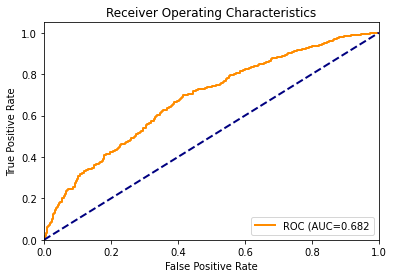

In [24]:
# Import model
from sklearn.linear_model import SGDClassifier

# Instantiate
reg = SGDClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.decision_function(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "SGDClassifier - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "SGDClassifier - Defaults")

# Backup
dump(reg, "./models/Chris/05_SGDClassifier_Defaults.joblib")

### Attempt #6: RandomForest

Elapsed time is 0.437513 seconds.


targ      
          0     1
pred 0   31   368
     1   47  1954

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400


['../../models/Chris/06_RandomForest_Defaults.joblib']

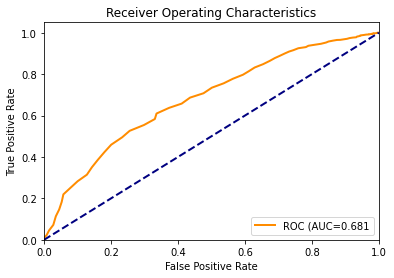

In [25]:
# Import model
from sklearn.ensemble import RandomForestClassifier

# Instantiate
reg = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ))

# Train
t.tic()
reg.fit(feat_trn, targ_trn)
t.toc()

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "RandomForest - Defaults")

# Backup
dump(reg, "./models/Chris/06_RandomForest_Defaults.joblib")

In [26]:
# **NOW** We're cookin with Gas!

### Attempt #7: Bagging

targ      
          0     1
pred 0   56   343
     1  141  1860

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,06/Feb 10:05,0.63222,0.92954,0.14035,0.88487


['../../models/Chris/07_Bagging_Defaults.joblib']

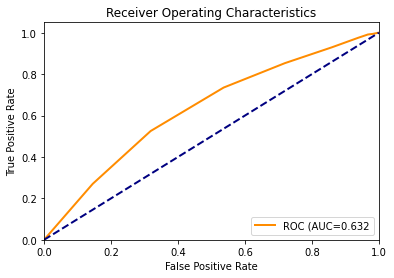

In [27]:
# Import model
from sklearn.ensemble import BaggingClassifier

# Instantiate
reg = BaggingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Bagging - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "Bagging - Defaults")

# Backup
dump(reg, "./models/Chris/07_Bagging_Defaults.joblib")

### Attempt #8: Gradient Boosting

targ      
          0     1
pred 0   21   378
     1   23  1978

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,06/Feb 10:05,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,06/Feb 10:05,0.69825,0.98851,0.05263,0.90796


['../../models/Chris/08_Boosting_Defaults.joblib']

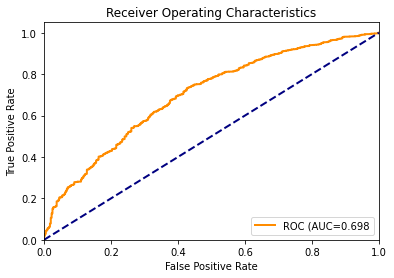

In [28]:
# Import model
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate
reg = GradientBoostingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Boosting - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "Boosting - Defaults")

# Backup
dump(reg, "./models/Chris/08_Boosting_Defaults.joblib")

In [29]:
# Slightly better than the ElasticNet models, not as good as the RandomForest

### Attempt #9: AdaBoost

targ      
          0     1
pred 0    9   390
     1   16  1985

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,06/Feb 10:05,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,06/Feb 10:05,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,06/Feb 10:05,0.68613,0.99200,0.02256,0.90722


['../../models/Chris/09_AdaBoost_Defaults.joblib']

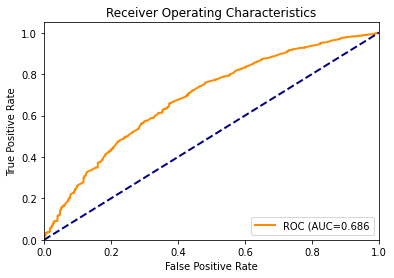

In [30]:
# Import model
from sklearn.ensemble import AdaBoostClassifier

# Instantiate
reg = AdaBoostClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "AdaBoost - Defaults - within bag", print=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "AdaBoost - Defaults")

# Backup
dump(reg, "./models/Chris/09_AdaBoost_Defaults.joblib")

### Attempt #10: LogisticRegression - RandomSearch

In [31]:
print(get_list_proportions(targ))

{0: 0.166375, 1: 0.833625}


Elapsed time is 223.897965 seconds.
{'C': 2.8778758791422523, 'penalty': 'l2', 'solver': 'lbfgs'}


targ      
          0     1
pred 0    2  1329
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,06/Feb 10:05,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,06/Feb 10:05,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,06/Feb 10:05,0.68613,0.99200,0.02256,0.90722


['../../models/Chris/10_LogisticRegression_RandomSearch.joblib']

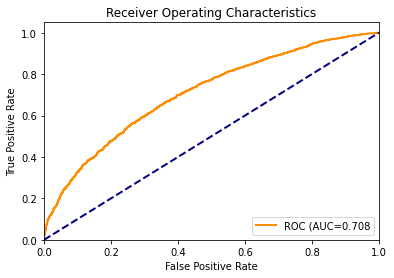

In [32]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from scipy.stats import uniform

# Instantiate
reg = LogisticRegression \
    ( class_weight=get_list_proportions(targ)
    , random_state=123
    , max_iter=1000
    )

# Define hyperparameters
params = dict \
    ( penalty=['l1', 'l2', 'elasticnet']
    , C=uniform(loc=0, scale=4)
    , solver=['lbfgs', 'saga']
    )

# Re-instantiate
clf = RandomizedSearchCV \
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
t.tic()
res = clf.fit(feat, targ)
t.toc()

# Check best params
print(res.best_params_)
# display(pd.DataFrame(res.cv_results_))

# Predict
pred = clf.predict(feat)
pred_prob = clf.predict_proba(feat)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(targ, pred, pred_prob, "LogisticRegression - RandomSearch")

# Backup
dump(reg, "./models/Chris/10_LogisticRegression_RandomSearch.joblib")

### Attempt 11: RandomForest - RandomSearch

In [62]:
print(get_list_proportions(targ_trn))

{0: 0.16642857142857143, 1: 0.8335714285714285}


In [34]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

# Instantiate
reg = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ)
    )

# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=100, high=500)
    , max_depth=[5,10,20,50,75,100,200]
    , min_samples_split=randint(low=1, high=10)
    , min_samples_leaf=randint(low=1, high=10)
    , min_weight_fraction_leaf=uniform(loc=0, scale=1)
    , min_impurity_decrease=uniform(loc=0, scale=0.5)
    , bootstrap=[True,False]
    , oob_score=[True,False]
    , ccp_alpha=uniform(loc=0, scale=5)
    )

# Re-instantiate
clf = RandomizedSearchCV \
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
t.tic()
res = clf.fit(feat, targ)
t.toc()

# Check best params
print(res.best_params_)

# Predict
pred = clf.predict(feat)
pred_prob = clf.predict_proba(feat)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(targ, pred, pred_prob, "RandomForest - RandomSearch")

# Backup
dump(reg, "./models/Chris/11_RandomForest_RandomSearch.joblib")

Elapsed time is 504.951059 seconds.
{'bootstrap': True, 'ccp_alpha': 2.1393174541890976, 'max_depth': 100, 'min_impurity_decrease': 0.4247158970388948, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.4172099480253376, 'n_estimators': 313, 'oob_score': True}


ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. ... 1. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

targ      
          0     1
pred 0    0  1331
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,06/Feb 10:04,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,06/Feb 10:04,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,06/Feb 10:05,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,06/Feb 10:05,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,06/Feb 10:05,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,06/Feb 10:05,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,06/Feb 10:05,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,06/Feb 10:05,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,06/Feb 10:05,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,06/Feb 10:05,0.68613,0.99200,0.02256,0.90722


['../../models/Chris/11_RandomForest_RandomSearch.joblib']

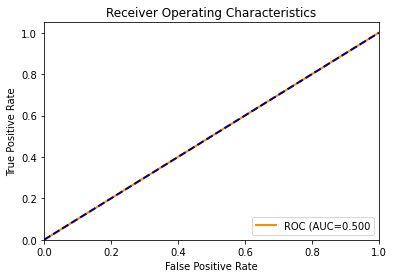

In [35]:
# Predict
pred = clf.predict(feat)
pred_prob = clf.predict_proba(feat)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print=False)
save_reg_perf(targ, pred, pred_prob, "RandomForest - RandomSearch")

# Backup
dump(reg, "./models/Chris/11_RandomForest_RandomSearch.joblib")

## Final Processing & Submitting

### Define final processing steps

In [57]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="./data/raw/test.csv"
    , submission_data_path:str="./data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "./data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "./data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop('Id')
    test_data = test_data.drop(['Id_old'], axis=1)
    test_data = data_scaler.fit_transform(test_data)

    # Get prediction
    final_prediction = final_model.predict_proba(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction[:,1])], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    # submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [58]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "./models/Chris/07_Bagging_Defaults.joblib"
    , data_scaler_path = "./models/Chris/scaler.joblib"
    , test_data_path = "./data/raw/test.csv"
    , submission_data_path = "./data/external/final.csv"
    , check = True
    )

,Id,TARGET_5Yrs
0,0,0.5
1,1,0.6
2,2,1.0
3,3,0.9
4,4,1.0
...,...,...
3794,3794,0.9
3795,3795,0.8
3796,3796,0.6
3797,3797,1.0


### Submit to Kaggle

In [59]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [60]:
# Call the API
if True:
    call_kaggle_api \
        ( upload_file = "./data/external/final.csv"
        , upload_message = "Ctrl-Alt-Elite_RandomForest_Defaults"
        )